<a href="https://colab.research.google.com/github/prp20/PytorchLearning/blob/main/Heart_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00


In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:49<00:00, 35.0MB/s]
100% 3.66G/3.66G [01:49<00:00, 36.0MB/s]


In [3]:
!unzip /content/rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [4]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
labels = pd.read_csv("/content/rsna_heart_detection.csv")
labels

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224
...,...,...,...,...,...,...,...,...
491,heart,82,47,76,123,7e413a9c-e331-4188-999c-7cf064cb2417,224,224
492,heart,85,48,79,89,6ab9618a-7d03-432f-8874-8596de1bfe26,224,224
493,heart,81,50,55,96,5f531888-0bcd-44fa-8acb-9f5b71609c38,224,224
494,heart,77,68,84,104,414e4a00-bec4-4552-92d3-7e710b367869,224,224


In [6]:
ROOT_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("Preprocess-Heart-Detection")

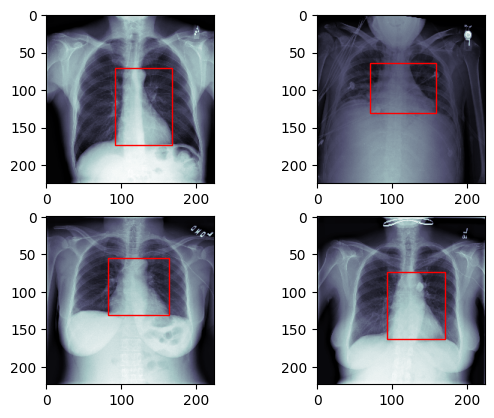

In [7]:
fig, axis = plt.subplots(2,2)
c = 0
for i in range(2):
  for j in range(2):
    data = labels.iloc[c]
    patientid = data['name']
    dcm_path = ROOT_PATH / str(patientid)
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = cv2.resize(dcm_array, (224, 224))

    x = data["x0"]
    y = data["y0"]
    width = data["w"]
    height = data['h']

    axis[i][j].imshow(dcm_array, cmap="bone")
    rect = patches.Rectangle((x,y), width, height,
                             linewidth=1, edgecolor = "r", facecolor="none")
    axis[i][j].add_patch(rect)
    c+=1

In [8]:
sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
  dcm_path = ROOT_PATH / str(patientid)
  dcm_path = dcm_path.with_suffix(".dcm")

  dcm = pydicom.read_file(dcm_path)
  dcm_array = dcm.pixel_array
  dcm_array = (cv2.resize(dcm_array, (224, 224))/255).astype(np.float16)
  train_or_val = "train" if counter < 400 else "val"

  if train_or_val == "train":
    train_ids.append(patient_id)
  else:
    val_ids.append(patient_id)

  current_save_path = SAVE_PATH/train_or_val
  current_save_path.mkdir(parents = True, exist_ok=True)

  np.save(current_save_path/patient_id, dcm_array)
  normalizer = 224*224
  if train_or_val == "train":
    sums += np.sum(dcm_array)/normalizer
    sums_squared += (dcm_array ** 2).sum() / normalizer

In [9]:
import os
os.mkdir("Processed-Heart-Detection")
np.save("Processed-Heart-Detection/train-subjects", train_ids)
np.save("Processed-Heart-Detection/val-subjects", val_ids)

In [10]:
mean = sums/len(train_ids)
std = np.sqrt((sums_squared/len(train_ids)) - mean **2)

mean, std

(0.4441964285714261, 0.28247853844340615)

In [11]:
import torch
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [12]:
class CardiacDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_labels_csv, patients, root_path, augs):
    self.labels = pd.read_csv(path_to_labels_csv)
    self.patients = np.load(patients)
    self.root_path = Path(root_path)
    self.augment = augs

  def __len__(self):
    return len(self.patients)

  def __getitem__(self, idx):
    patient = self.patients[idx]
    data = self.labels[self.labels['name'] == patient]
    x_min = data['x0'].item()
    y_min = data['y0'].item()
    x_max = x_min + data['w'].item()
    y_max = y_min + data['h'].item()

    bbox = [x_min, y_min, x_max, y_max]

    file_path = self.root_path/patient
    img = np.load(f"{file_path}.npy").astype(np.float32)

    if self.augment:
      bb = BoundingBox(x1=bbox[0], y1 = bbox[1], x2 = bbox[2], y2 = bbox[3])
      random_seed = torch.randint(0, 10000, (1,)).item()
      imgaug.seed(random_seed)
      img, aug_bbox = self.augment(image=img, bounding_boxes= bb)
      bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

    img = (img - 0.4441)/0.2824
    img = torch.tensor(img).unsqueeze(0)
    bbox = torch.tensor(bbox)
    return  img, bbox


In [13]:
!pip install torchmetrics lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 26.5 MB/s eta 0:00:00


In [14]:
import imgaug.augmenters as iaa
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [15]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale = (0.8,1.2),
        rotate = (-10, 10),
        translate_px = (-10, 10)
    )
])

labels_path = "rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train-subjects.npy"
train_root = "/content/Preprocess-Heart-Detection/train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)


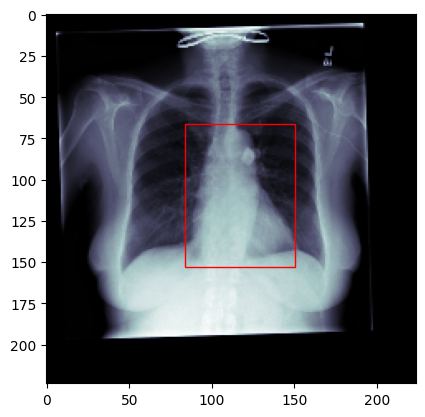

In [16]:
img, bbox = dataset[0]
fig, axis = plt.subplots(1,1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

In [17]:
train_root_path = "/content/Preprocess-Heart-Detection/train"
train_subjects = "/content/Processed-Heart-Detection/train-subjects.npy"

val_root_path = "/content/Preprocess-Heart-Detection/val"
val_subjects = "/content/Processed-Heart-Detection/val-subjects.npy"

In [18]:
train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale = (0.8,1.2),
        rotate = (-10, 10),
        translate_px = (-10, 10)
    )
])

In [19]:
train_dataset = CardiacDataset("rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [20]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=False)

In [21]:
class CardiacDetection(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.model = torchvision.models.resnet18(pretrained=True)
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
    self.model.fc = torch.nn.Linear(in_features = 512, out_features=4)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.MSELoss()

  def forward(self, data):
    return self.model(data)

  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)
    loss = self.loss_fn(pred, label)
    self.log("Train Loss", loss)
    if batch_idx % 50 == 0:
      self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
    return loss

  def validation_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)
    loss = self.loss_fn(pred, label)
    self.log("Val Loss", loss)
    if batch_idx % 50 == 0:
      self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
    return loss

  def log_images(self, x_ray, pred, label, name):
    results = []
    for i in range(4):
      coords_labels = label[i]
      coords_pred = pred[i]

      img = ((x_ray[i] * 0.2824) + 0.4441).numpy()[0]
      x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
      x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
      img = cv2.rectangle(img, (x0, y0), (x1, y1), (0,0,0), 2)

      x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
      x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
      img = cv2.rectangle(img, (x0, y0), (x1, y1), (1,1,1), 2)

      results.append(torch.tensor(img).unsqueeze(0))

    grid = torchvision.utils.make_grid(results, 2)
    self.logger.experiment.add_image(name, grid, self.global_step)

  def configure_optimizers(self):
    return [self.optimizer]

In [22]:
model = CardiacDetection()

checkpoint_callback = checkpoint_callback = ModelCheckpoint(monitor="Val Loss",
                                      dirpath='/content/',
                                      filename='cardiac_detection',
                                      save_top_k=10,
                                      mode="min")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [23]:
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CardiacDetection.load_from_checkpoint("/content/cardiac_detection-v9.ckpt")
model.eval()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CardiacDetection(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [27]:
preds = []
labels = []

with torch.no_grad():
  for data, label in val_dataset:
    data = data.to(device).float().unsqueeze(0)
    pred = model(data)[0].cpu()
    preds.append(pred)
    labels.append(label)

preds = torch.stack(preds)
labels = torch.stack(labels)


In [29]:
abs(preds-labels).mean(0)

tensor([10.8049,  9.4176, 53.6062, 48.3865])

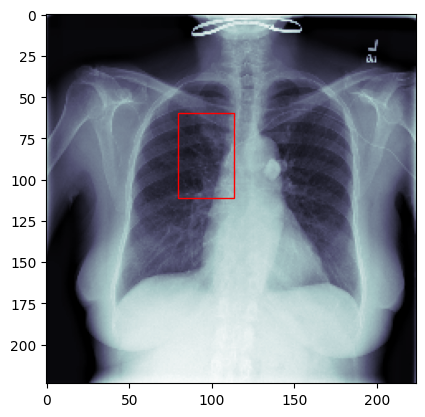

In [35]:
IDX = 30

img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axis = plt.subplots(1,1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], edgecolor="r", facecolor="none")
axis.add_patch(heart)